In [42]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
from sklearn.cluster import KMeans
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [43]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
lr = 0.001
num_outputs = 10
batch_size = 100
in_features = 2
noise = False
model = transformer.Transformer(d_model, nhead, nhid, nlayers, in_features=in_features,buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
criterion = nn.CrossEntropyLoss()
model.criterion = criterion

Using device: Quadro P1000
total params:2113290


In [44]:
model.load_state_dict(torch.load("C:\\Users\\prajb\\OneDrive\\Documents\\TU Delft CSE Masters Y2\\Thesis Projects\\PFN clustering\\conditional_two_features.pt", weights_only=True))
model.eval() 

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=256, out_features=10, bias=True)
  (linear_x): Sequential(
    (0): Normalize()
    (1): Linear(in_features=2, out_features=256, bias=True)
  )
  (linear_num_clusters): Linear(in_features=1,

In [45]:
%matplotlib inline
temp_batch_size = 10
std_variation = True
random_seed = 42
train_X, train_Y, y_target_noisy, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,num_classes=num_outputs, kmeans=True,std_variation = std_variation) 
print(len(train_X))

121


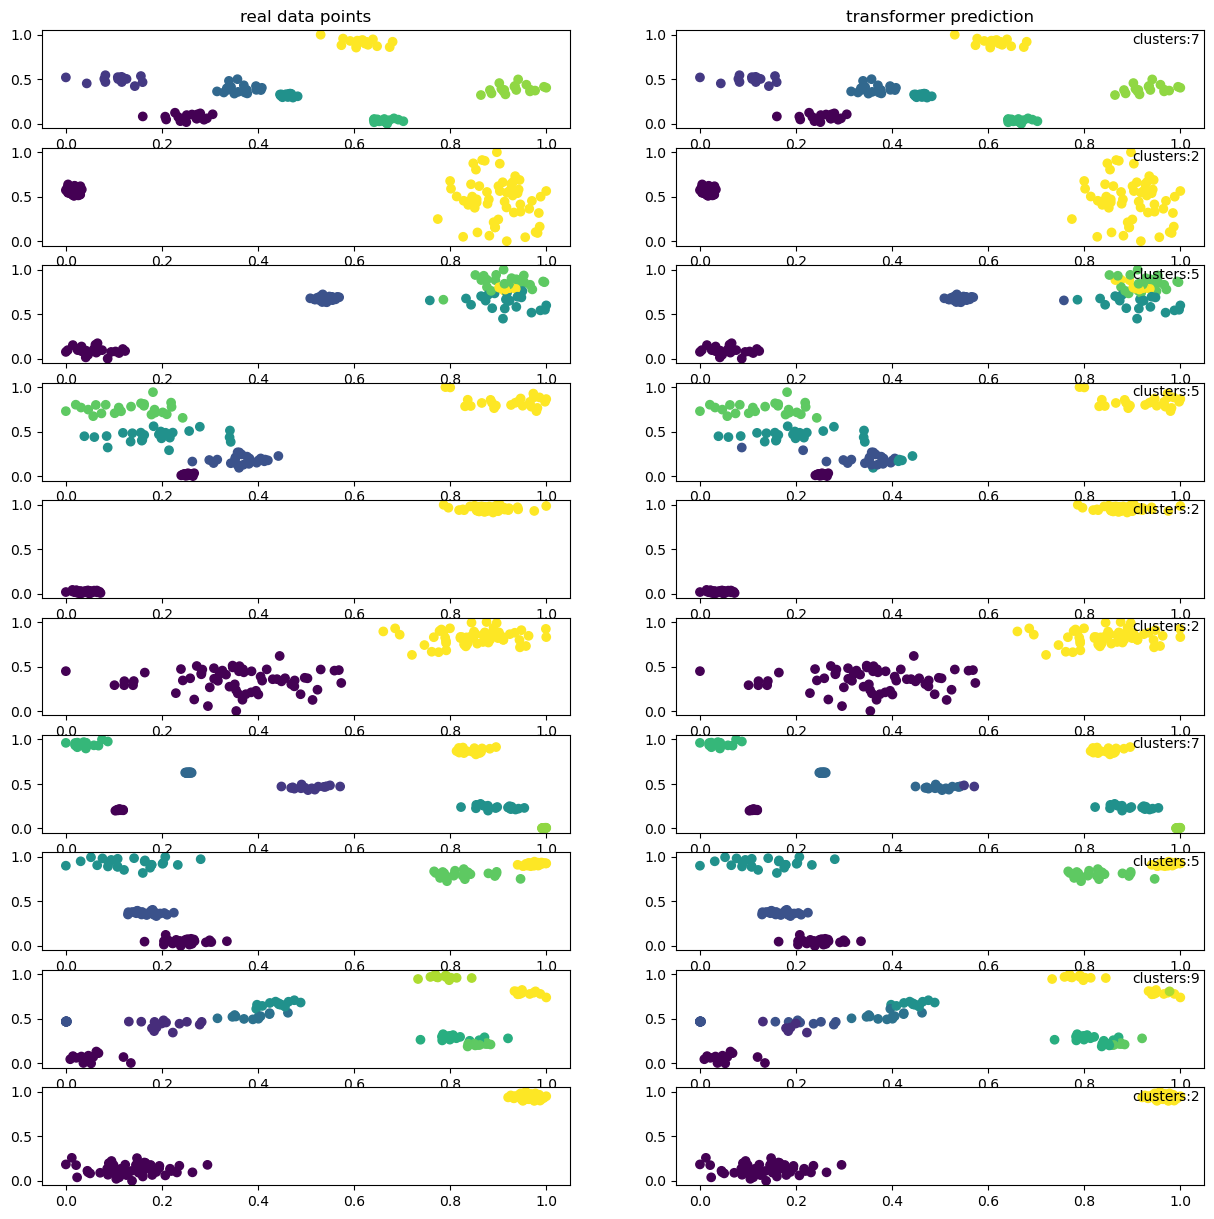

In [46]:
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(15, 15)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[2 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits,cluster_output = model(train_x)
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[2 * batch_index + 1].text(0.9, 0.9, f"clusters:{predictions_cluster_count.cpu().item() + 1}") 

axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()

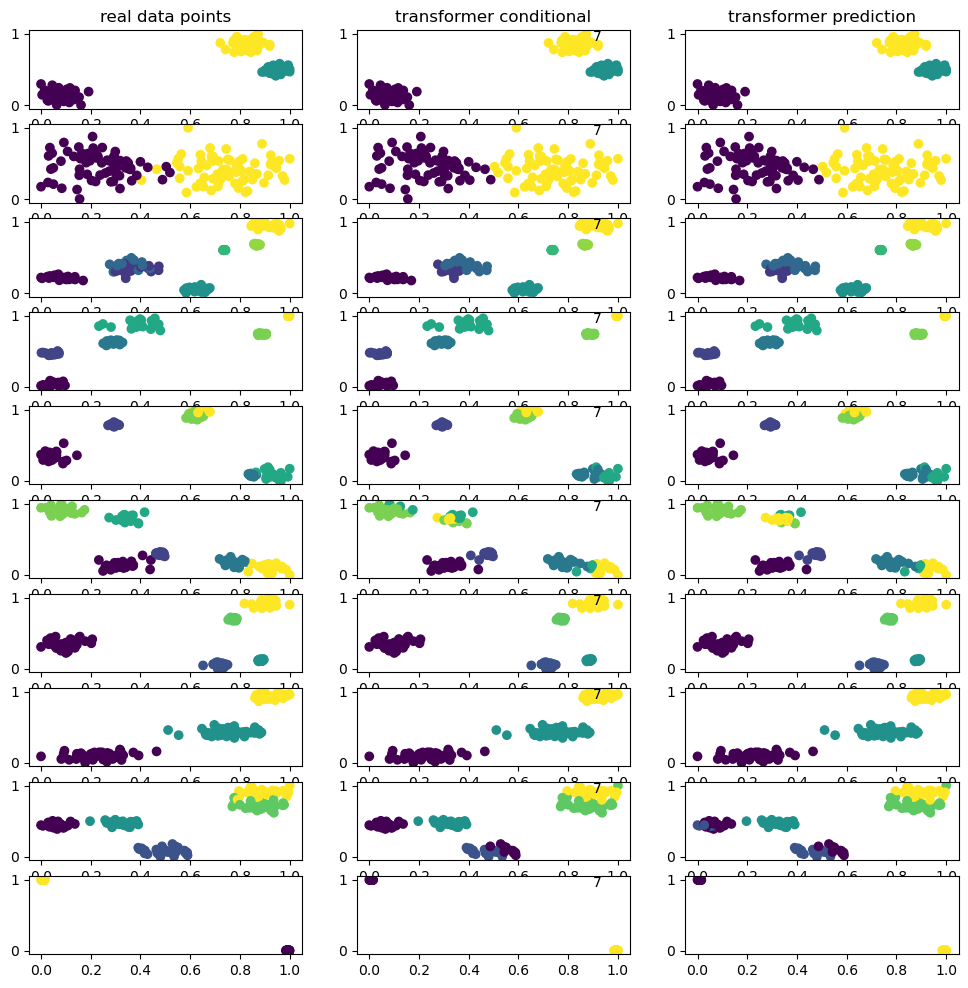

In [58]:
# # Set up grid for subplots
%matplotlib inline
temp_batch_size = 10
std_variation = True
train_X, train_Y, y_target_noisy, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,num_classes=7, kmeans=True,std_variation = std_variation) 
fig, axes = plt.subplots(temp_batch_size, 3, figsize=(12, 12)) 
rand = random.randint(2,5)
rand = 7
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[3 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    random_cluster = torch.tensor([rand], dtype=torch.float32).unsqueeze(0).to(device)
    logits,cluster_output = model(train_x,random_cluster)
    logits = logits.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    axes[3 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[3 * batch_index + 1].text(0.9, 0.9, f"{rand}") 

    logits,cluster_output = model(train_x)
    logits = logits.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[3 * batch_index +2].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())

axes[1].set_title(f"transformer conditional")
axes[0].set_title(f"real data points")
axes[2].set_title(f"transformer prediction")
plt.show()

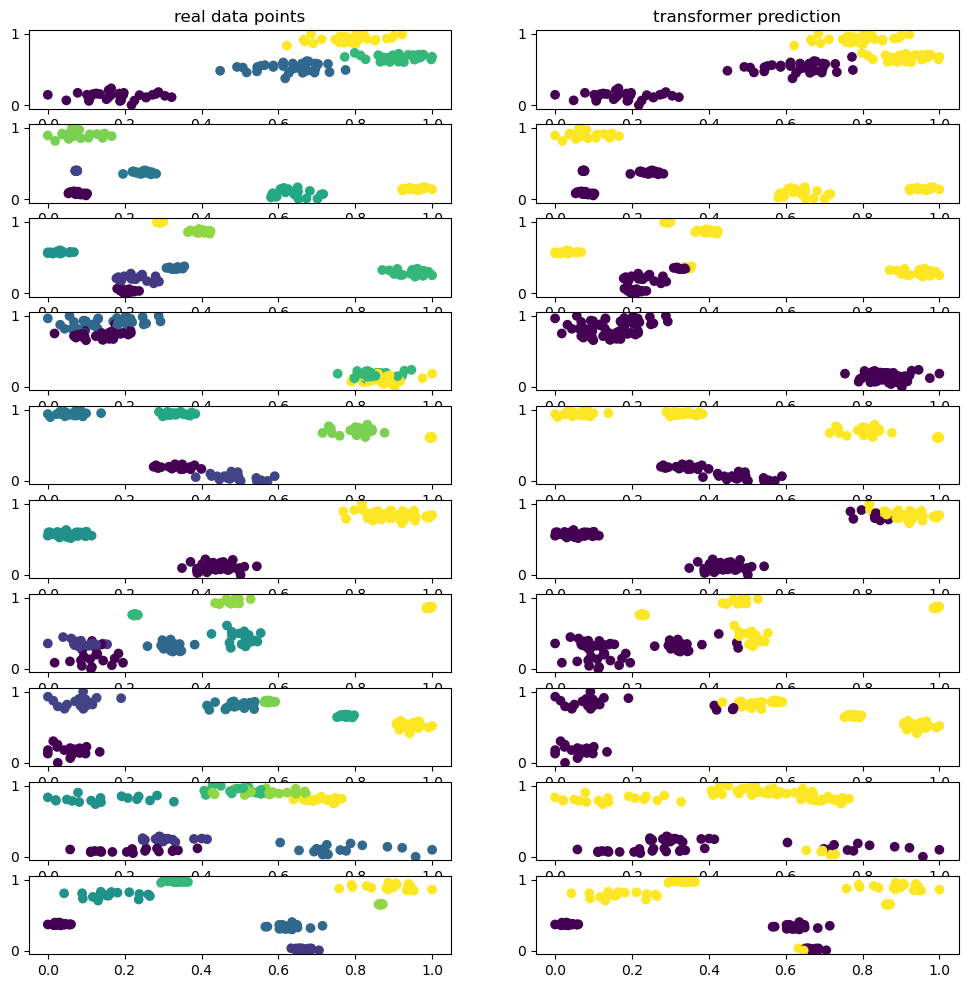

In [72]:
# # Set up grid for subplots
%matplotlib inline
temp_batch_size = 10
std_variation = True
train_X, train_Y, y_target_noisy, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,num_classes=7, kmeans=True,std_variation = std_variation) 
fig, axes = plt.subplots(temp_batch_size, 2, figsize=(12, 12)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index].unsqueeze(1)
    train_y = train_Y[:, batch_index] 
    axes[2 * batch_index].scatter(train_x[:, 0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits,cluster_output = model(train_x)
    mask = torch.ones_like(logits)
    mask[:, :, -9:] = 0
    logits = logits * mask
    logits = logits.squeeze(1)
    cluster_output = cluster_output.squeeze(1)
    predictions = torch.argmax(logits, dim=1)
    predictions_cluster_count = torch.argmax(cluster_output, dim=1)
    axes[2 * batch_index +1].scatter(train_x[:,0, 0].cpu().numpy() , train_x[:,0, 1].cpu().numpy() , c=predictions.cpu().numpy())
    
axes[1].set_title(f"transformer prediction")
axes[0].set_title(f"real data points")
plt.show()